In [2]:
import os, sys
cwd = os.getcwd()
# sys.path.insert(0, f"{cwd}/../")
sys.path.insert(0, "/home/emmanuel/code/rbig")

# RBIG Packages
from rbig.data import ToyData
from rbig.layers import RBIGBlock, RBIGParams
from rbig.models import RBIGModel


from typing import Iterable, Optional, Dict, NamedTuple, Tuple, Union
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from rbig.base import DensityTransformerMixin, ScoreMixin

import numpy as np
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(["seaborn-paper"])

%load_ext autoreload
%autoreload 2

## Data

<Figure size 360x360 with 0 Axes>

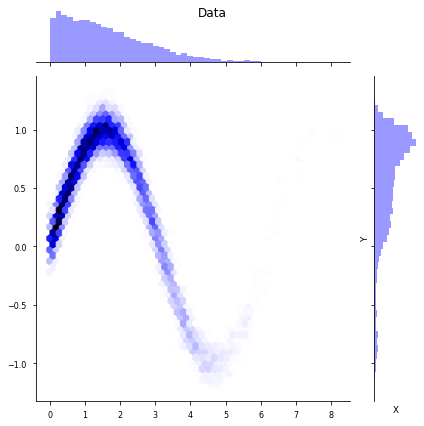

In [4]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()
    
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 10_000
noise = 0.1
random_state=123
n_features = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state
).generate_samples()

plot_2d_joint(data, title='Data')

## Model - RBIG

In [14]:
# initialize rbig model
rbig_model = RBIGModel()

# transform data
X_trans, _ = rbig_model.fit_transform(data)

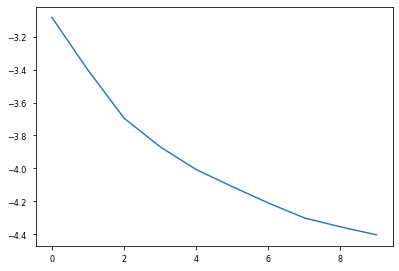

In [15]:
plt.plot(rbig_model.losses_)

## Loss Function I - Maximum # layers

In [47]:
from rbig.losses import MaxLayers

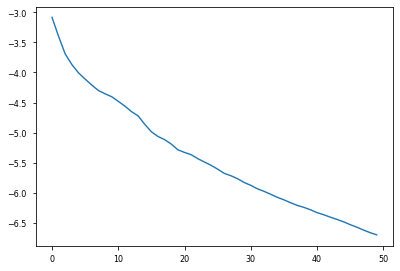

<Figure size 360x360 with 0 Axes>

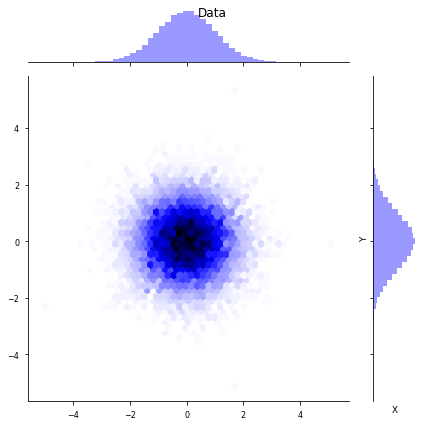

In [50]:
# initialize params
rbig_params = RBIGParams()

# initialize rbig model
rbig_loss = MaxLayers(n_layers=50)

rbig_model = RBIGModel(rbig_params, rbig_loss)

# transform data to latent space
Z, _ = rbig_model.fit_transform(data)

# plot loss
plt.plot(rbig_model.losses_)
plot_2d_joint(Z, title='Data')

## Loss II - Information Reduction

In [51]:
from rbig.losses import InformationLoss

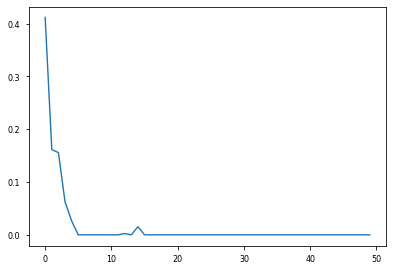

<Figure size 360x360 with 0 Axes>

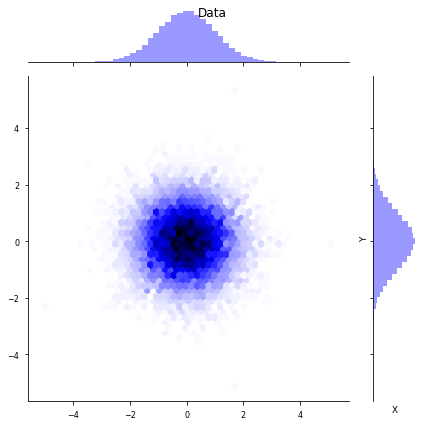

In [62]:
# initialize params
rbig_params = RBIGParams()

# initialize rbig model
rbig_loss = InformationLoss(tol_layers=50, method='kde')

rbig_model = RBIGModel(rbig_params, rbig_loss)

# transform data
X_trans, _ = rbig_model.fit_transform(data)

# plot loss
plt.plot(rbig_model.losses_)
plot_2d_joint(X_trans, title='Data')

In [56]:
print(np.sum(rbig_model.losses_))

0.9799065640409519


### Calculate the Marginal Entropy

In [39]:
import os, sys
cwd = os.getcwd()
# sys.path.insert(0, f"{cwd}/../")
sys.path.insert(0, "/home/emmanuel/code/pysim")

from rbig.information.entropy import marginal_entropy
from rbig.information.reduction import ReductionParams

In [33]:
X_trans.shape

(10000, 2)

In [34]:
# entropy data
H_data = marginal_entropy(data, 'histogram')
print("Entropy (data):", H_data)

# entropy of transformed data
H_trans = marginal_entropy(X_trans, 'histogram')
print("Entropy (data):", H_trans)

Entropy (data): [1.41609785 0.48577266]
Entropy (data): [1.06538761 1.28526056]


#### Change in Information

In [60]:
for estimator in ['kde', 'histogram', 'knn', 'gauss']:
    H_delta = InformationLoss(method=estimator).calculate_loss(X_trans, data)
    print(f"Estimator: {estimator}\nDelta H: {H_delta:.4f}",)

Estimator: kde
Delta H: 0.8347
Estimator: histogram
Delta H: 0.9370
Estimator: knn
Delta H: 0.9178
Estimator: gauss
Delta H: 1.0384


In [61]:
%timeit _ = InformationLoss(method='kde').calculate_loss(X_trans, data)
%timeit _ = InformationLoss(method='knn').calculate_loss(X_trans, data)
%timeit _ = InformationLoss(method='histogram').calculate_loss(X_trans, data)
%timeit _ = InformationLoss(method='gauss').calculate_loss(X_trans, data)

855 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
64.1 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.94 ms ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.09 ms ± 3.32 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Model - RBIG, N Layers